In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os 
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import csv
import cv2
import math
import PIL
from collections import namedtuple, OrderedDict
import io
from PIL import Image
from collections import namedtuple, OrderedDict

%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
DATA_DIR = '../input/airbus-ship-detection/'
ROOT_DIR = '/kaggle/working'
os.chdir(ROOT_DIR)

In [3]:
train_v2_list = os.listdir(DATA_DIR + 'train_v2')

# **Training data**

In [4]:
train_df = pd.read_csv(DATA_DIR + "train_ship_segmentations_v2.csv")
train_df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [5]:
train_df['ShipCount'] = train_df.groupby('ImageId')['ImageId'].transform('count')
train_df.loc[train_df['EncodedPixels'].isnull().values,'ShipCount'] = 0

In [6]:
train_df

,ImageId,EncodedPixels,ShipCount
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5
...,...,...,...
231718,fffedbb6b.jpg,NaN,0
231719,ffff2aa57.jpg,NaN,0
231720,ffff6e525.jpg,NaN,0
231721,ffffc50b4.jpg,NaN,0


In [7]:
count_df = train_df.groupby('ShipCount').count()
count_df

,ImageId,EncodedPixels
ShipCount,,
0,150000,0
1,27104,27104
2,15348,15348
3,8862,8862
4,6488,6488
5,4625,4625
6,3942,3942
7,2842,2842
8,2544,2544


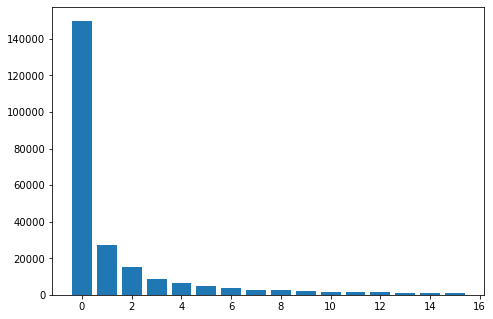

In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(count_df.index.values.tolist(), list(count_df['ImageId']))
plt.show()

# Image Enhancement

In [9]:
sampleList = ['001aee007.jpg','001234638.jpg','001f04ca3.jpg','000d26c17.jpg']
sampleImgList = []
for x in sampleList:
    sampleImgList.append(mpimg.imread(DATA_DIR + 'train_v2/' + x))

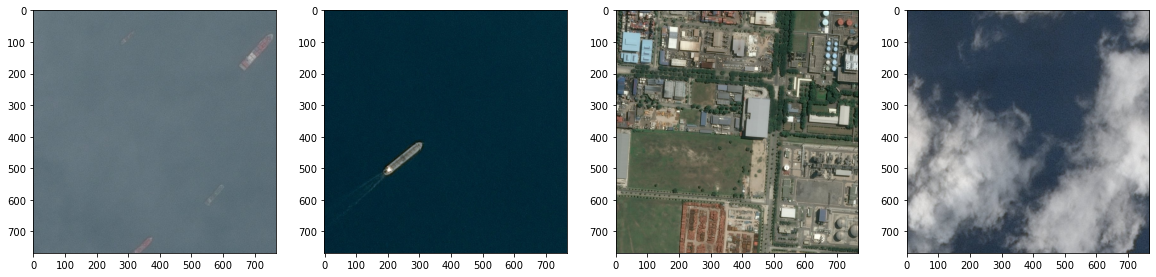

In [10]:
fig = plt.figure(1,figsize=(20,10))
for i in range(len(sampleImgList)):
    image_tmp = sampleImgList[i]
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(image_tmp)

In [11]:
from skimage.feature import canny
from skimage.filters import scharr, unsharp_mask
from skimage import exposure
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value

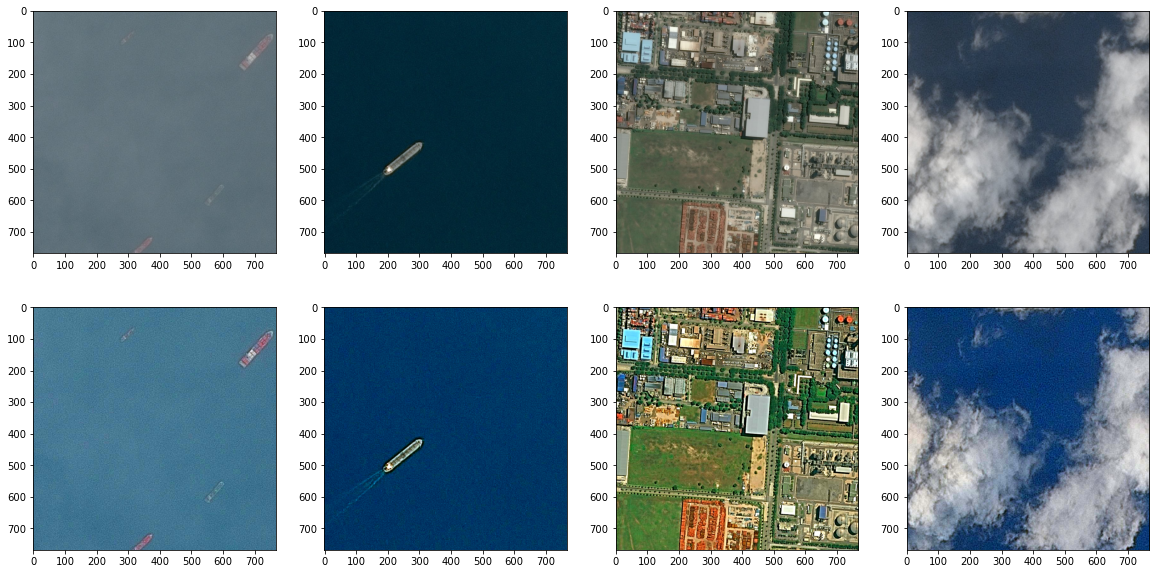

In [12]:
fig = plt.figure(1,figsize=(20,20))
for i in range(len(sampleImgList)):
    image_tmp = sampleImgList[i]
    ax = fig.add_subplot(2,4,i+1)
    ax.imshow(image_tmp)
    image_tmp = unsharp_mask(sampleImgList[i], radius=4, amount=2)
    sampleImgList[i] = image_tmp
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(image_tmp)

# Decoding the pixels

In [13]:
def rle_to_pixels(rle_code):
    '''
    Transforms a RLE code string into a list of pixels of a (768, 768) canvas
    '''
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
                 for pixel_position in range(start, start + length)]
    return pixels

def get_all_masks(image_id):
    ret = []
    s = train_df[train_df['ImageId'] == image_id]['EncodedPixels']
    if not s.isnull().values.any():
        for x in s:
            ret.append(rle_to_pixels(x))
    return ret

def show_masks(image_id):
    canvas = np.zeros((768, 768))
    masks = get_all_masks(image_id)
    for x in masks:
       canvas[tuple(zip(*x))] = 1
    return canvas

def find_bounding_box(pixels):
    xmin = pixels[0][0]
    xmax = pixels[0][0]
    ymin = pixels[0][1]
    ymax = pixels[0][1]
    for p in pixels:
        px = p[0]
        py = p[1]
        if px < xmin:
            xmin = px
        if px > xmax:
            xmax = px
        if py < ymin:
            ymin = py
        if py > ymax:
            ymax = py
    return xmin, ymin, xmax, ymax

def get_all_boxes(image_id):
    ret = []
    masks = get_all_masks(image_id)
    for x in masks:
        ret.append(find_bounding_box(x))
    return ret

def show_bounding_box(image_id):
    canvas = np.array(PIL.Image.open(DATA_DIR + 'train_v2/' + image_id))
    boxes = get_all_boxes(image_id)
    for x in boxes:
        xmin, ymin, xmax, ymax = x[0],x[1], x[2], x[3]
        canvas[xmin][ymin : ymax] = [0,255,0]
        canvas[xmax][ymin : ymax] = [0,255,0]
        canvas[:,ymin][xmin : xmax] = [0,255,0]
        canvas[:,ymax][xmin : xmax] = [0,255,0]
    return canvas

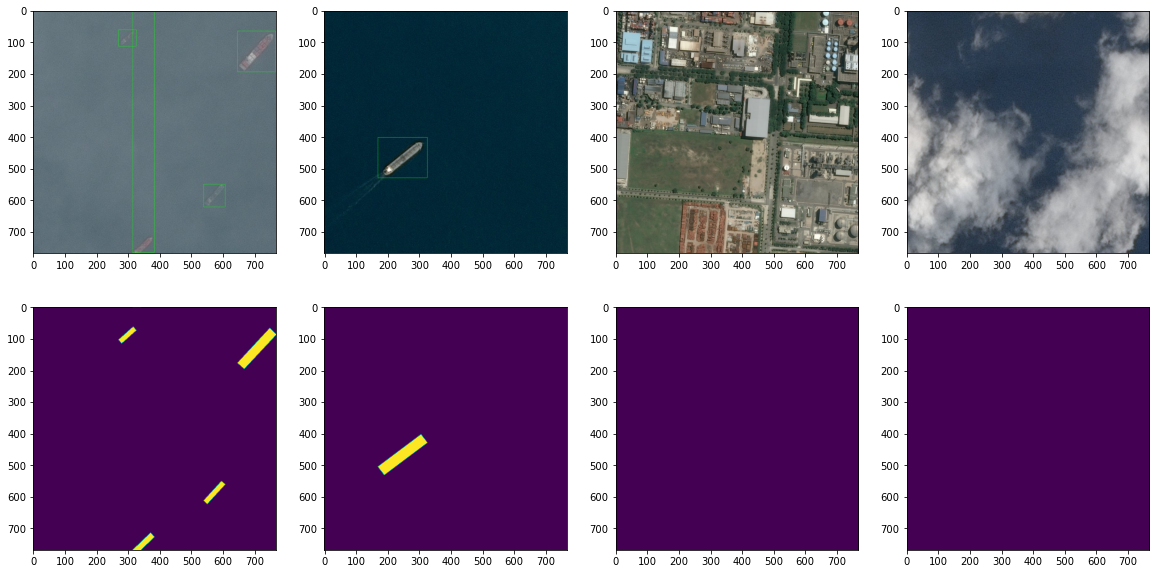

In [14]:
fig = plt.figure(1,figsize=(20,20))
for i in range(len(sampleList)): 
    image_tmp = show_masks(sampleList[i])
    ax = fig.add_subplot(1,4,i+1)
    ax.imshow(image_tmp)
    image_tmp = show_bounding_box(sampleList[i])
    ax = fig.add_subplot(2,4,i+1)
    ax.imshow(image_tmp)

# Tensorflow Object Detection API setup

In [15]:
#Make sure to enable TPU

In [16]:
#Change TF version
!pip install tensorflow-gpu==2.2

     |████████████████████████████████| 516.2 MB 3.2 kB/s  eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [17]:
import tensorflow as tf

In [18]:
tf.__version__

'2.2.0'

In [43]:
!pip install tensorflow-object-detection-api

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [20]:
os.chdir(ROOT_DIR)
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 43409, done.
remote: Total 43409 (delta 0), reused 0 (delta 0), pack-reused 43409
Receiving objects: 100% (43409/43409), 550.10 MiB | 30.27 MiB/s, done.
Resolving deltas: 100% (29533/29533), done.


In [21]:
!apt-get -y install protobuf-compiler
!pip install Cython
!pip install pillow
!pip install lxml
!pip install jupyter
!pip install matplotlib
!pip install tf_slim

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libprotobuf10 libprotoc10
The following NEW packages will be installed:
  libprotobuf10 libprotoc10 protobuf-compiler
0 upgraded, 3 newly installed, 0 to remove and 59 not upgraded.
Need to get 1242 kB of archives.
After this operation, 4942 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libprotobuf10 amd64 3.0.0-9.1ubuntu1 [651 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libprotoc10 amd64 3.0.0-9.1ubuntu1 [566 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 protobuf-compiler amd64 3.0.0-9.1ubuntu1 [24.5 kB]
Fetched 1242 kB in 0s (3836 kB/s)             
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package libprotobuf10:amd64.
(Reading database ... 107745 files and directories currently instal

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 352 kB 403 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [22]:
os.chdir(ROOT_DIR+"/models/research/")
!protoc object_detection/protos/*.proto --python_out=.
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
os.environ['PYTHONPATH'] += ':/kaggle/working/models/research/:/kaggle/working/models/research/slim/:/kaggle/working/models'

In [23]:
#Test if set up is successful
!python object_detection/builders/model_builder_test.py

In [24]:
os.chdir(ROOT_DIR)

# LabelMap

In [25]:
with open(ROOT_DIR+'/labelmap.pbtxt', 'w+') as the_file:
    the_file.write('item\n')
    the_file.write('{\n')
    the_file.write('id :{}'.format(int(1)))
    the_file.write('\n')
    the_file.write("name :'{0}'".format('ship'))
    the_file.write('\n')
    the_file.write('}\n')
    the_file.close()

# Generate annotations

## Generate xml files

In [26]:
import xml.etree.cElementTree as ET
def generate_xml(imageId):
    annotation = ET.Element("annotation")
    ET.SubElement(annotation, "folder").text = "train_v2"
    ET.SubElement(annotation, "filename").text = imageId
    source = ET.SubElement(annotation, "source")
    ET.SubElement(source, "database").text = "Unknown"
    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = "768"
    ET.SubElement(size, "height").text = "768"
    ET.SubElement(size, "depth").text = "3"
    ET.SubElement(annotation, "segmented").text = "0"
    
    boxes = get_all_boxes(imageId)
    for b in boxes:
        object1 = ET.SubElement(annotation, "object")
        ET.SubElement(object1, "name").text = "ship"
        ET.SubElement(object1, "name").text = "ship"
        ET.SubElement(object1, "pose").text = "Unspecified"
        ET.SubElement(object1, "truncated").text = "0"
        ET.SubElement(object1, "difficult").text = "0"
        bndbox = ET.SubElement(object1, "bndbox")
        xmin, ymin, xmax, ymax = b
        ET.SubElement(bndbox, "xmin").text = str(xmin)
        ET.SubElement(bndbox, "ymin").text = str(ymin)
        ET.SubElement(bndbox, "xmax").text = str(xmax)
        ET.SubElement(bndbox, "ymax").text = str(ymax)

    tree = ET.ElementTree(annotation)
    tree.write("test.xml")

## Generate dataframe for TFRecords

In [27]:
data = []
###############################################DEBUG
for x in train_df['ImageId'][:100]:
    boxes = get_all_boxes(x)
    for b in boxes:
        xmin, ymin, xmax, ymax = b
        data.append((x, 768, 768, 'ship', xmin, ymin, xmax, ymax))
columns_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
TFRcords_df = pd.DataFrame(data=data, columns=columns_name)
TFRcords_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,000155de5.jpg,768,768,ship,466,344,501,447
1,000194a2d.jpg,768,768,ship,288,469,307,491
2,000194a2d.jpg,768,768,ship,378,67,386,84
3,000194a2d.jpg,768,768,ship,175,258,185,305
4,000194a2d.jpg,768,768,ship,387,72,387,78
...,...,...,...,...,...,...,...,...
178,0017c19d6.jpg,768,768,ship,450,528,469,547
179,0017c19d6.jpg,768,768,ship,515,428,527,441
180,0017c19d6.jpg,768,768,ship,450,528,469,547
181,0018e5d6c.jpg,768,768,ship,128,72,205,354


# Training & validation split

In [28]:
#A naive way to split for code testing

train_set = TFRcords_df[0:20]
valid_set = TFRcords_df[21:25]

In [29]:
sys.path.append("..")
from models.research.object_detection.utils import dataset_util
from models.research.object_detection.utils import label_map_util

In [30]:
# Function to group data and return the same
# Group by imagefile name
def make_groups(df, field=None):
    if field==None:
        field = 'filename'

    data = namedtuple('object', ['filename', 'info'])
    grouped = df.groupby(field)

    grouped_data = []
    for filename, x in zip(grouped.groups.keys(), grouped.groups):
        grouped_data.append(data(filename, grouped.get_group(x)))

    return grouped_data


In [31]:
# Creating a tf record sample
def create_tf_example(group, img_path, label_map_dict):
    # Read the imagefile. This will be used in features later 
    with tf.io.gfile.GFile(os.path.join(img_path, '{}'.format(group.filename)), 'rb') as f:
        img_file = f.read()

        # Encode to bytes and read using PIL. Could be done directly too
        encoded_img = io.BytesIO(img_file)
        # Read the image using PIL
        img = Image.open(encoded_img)
        width, height = img.size

      # Encode the name of the img file
        filename = group.filename.encode('utf8')

      # Define the format of the image file
        img_format = b'jpg'   # The name will be in bytes


      # Define the variables that you need as features
        xmins = []
        xmaxs = []
        ymins = []
        ymaxs = []
        classes_text = []
        classes = []

      # Iterate over the namedtuple object
        for index, row in group.info.iterrows():
            xmins.append(row['xmin'] / width)   # store normalized values for bbox
            xmaxs.append(row['xmax'] / width)
            ymins.append(row['ymin'] / height)
            ymaxs.append(row['ymax'] / height)
            classes_text.append(row['class'].encode('utf8'))
            classes.append(label_map_dict[row['class']])

        tf_example = tf.train.Example(features=tf.train.Features(feature={
          'image/height': dataset_util.int64_feature(height),
          'image/width': dataset_util.int64_feature(width),
          'image/filename': dataset_util.bytes_feature(filename),
          'image/source_id': dataset_util.bytes_feature(filename),
          'image/encoded': dataset_util.bytes_feature(img_file),
          'image/format': dataset_util.bytes_feature(img_format),
          'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
          'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
          'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
          'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
          'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
          'image/object/class/label': dataset_util.int64_list_feature(classes),}))

        return tf_example

## Create TFRecord Files

In [32]:
# Path where all the images are present
img_path = DATA_DIR + 'train_v2'
# Label map
label_map_dict = label_map_util.get_label_map_dict(ROOT_DIR + '/labelmap.pbtxt')

writer = tf.compat.v1.python_io.TFRecordWriter('./train.record')

# create groups in the df. One image may contain several instances of an object hence the grouping thing
img_groups = make_groups(train_set, field='filename')
# Iterate over the samples in each group create a TFRecord
for group in img_groups:
    tf_example = create_tf_example(group, img_path, label_map_dict)
    writer.write(tf_example.SerializeToString())
# close the writer
writer.close()
print("TFRecords for training data  created successfully")


writer = tf.compat.v1.python_io.TFRecordWriter('./valid.record')
# create groups 
img_groups = make_groups(valid_set, field='filename')
# Iterate over the samples in each group create a TFRecord
for group in img_groups:
    tf_example = create_tf_example(group, img_path, label_map_dict)
    writer.write(tf_example.SerializeToString())
# close the writer
writer.close()
print("TFRecords for validation data created successfully")

TFRecords for training data  created successfully
TFRecords for validation data created successfully


# Import the model

In [33]:
#!cp /kaggle/working/models/research/object_detection/samples/configs/ssd_inception_v2_coco.config /kaggle/working

!cp /kaggle/working/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_coco.config /kaggle/working

In [34]:
#!wget download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
!wget download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz

--2020-09-06 18:03:14--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.217.128, 2607:f8b0:400c:c13::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.217.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444343592 (424M) [application/x-tar]
Saving to: ‘faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz’

faster_rcnn_incepti 100%[===================>] 423.76M  51.1MB/s    in 8.7s    

2020-09-06 18:03:23 (48.9 MB/s) - ‘faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz’ saved [444343592/444343592]



In [35]:
#!tar -xzf ssd_inception_v2_coco_2017_11_17.tar.gz
!tar -xzf faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz

In [36]:
#!mv ssd_inception_v2_coco_2017_11_17 ssd_inceptionv2
!mv faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8 mymodel

In [ ]:
!pip install git+https://github.com/waleedka/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI

# Configure the model config file

In [37]:
# Configures the .config automatically
#fin = open("ssd_inception_v2_coco.config", "rt")
#fout = open("ssd_inception_v2_coco2.config", "wt")

fin = open("faster_rcnn_inception_v2_coco.config", "rt")
fout = open("configfile.config", "wt")

for line in fin:
    if 'num_classes:' in line:
        fout.write('\t\tnum_classes: 1\n')
    else:
        #line = line.replace('PATH_TO_BE_CONFIGURED/model.ckpt', '/kaggle/working/ssd_inceptionv2/model.ckpt')
        line = line.replace('PATH_TO_BE_CONFIGURED/model.ckpt', '/kaggle/working/mymodel/model.ckpt')
        line = line.replace('PATH_TO_BE_CONFIGURED/mscoco_train.record-?????-of-00100', '/kaggle/working/train.record')
        line = line.replace('PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt', '/kaggle/working/labelmap.pbtxt')
        line = line.replace('PATH_TO_BE_CONFIGURED/mscoco_val.record-?????-of-00010','/kaggle/working/valid.record')
        fout.write(line)

fin.close()
fout.close()

# Training the model

In [47]:
!mkdir checkpoints
!cp /kaggle/working/models/research/object_detection/legacy/train.py /kaggle/working
!cp /kaggle/working/models/research/object_detection/legacy/eval.py /kaggle/working
!cp /kaggle/working/models/research/object_detection/export_inference_graph.py /kaggle/working
!cp /kaggle/working/models/research/object_detection/model_main.py /kaggle/working

In [48]:
#run the training
#!python train.py --logtostderr --train_dir=/kaggle/working/checkpoints/ --pipeline_config_path=/kaggle/working/ssd_inception_v2_coco2.config

!python train.py --logtostderr --train_dir=/kaggle/working/checkpoints/ --pipeline_config_path=/kaggle/working/configfile.config
#!python model_main.py --logtostderr --train_dir=/kaggle/working/checkpoints/ --pipeline_config_path=/kaggle/working/configfile.config

Traceback (most recent call last):
  File "model_main.py", line 25, in <module>
    from object_detection import model_lib
  File "/kaggle/working/models/research/object_detection/model_lib.py", line 29, in <module>
    from object_detection import eval_util
  File "/kaggle/working/models/research/object_detection/eval_util.py", line 35, in <module>
    from object_detection.metrics import coco_evaluation
  File "/kaggle/working/models/research/object_detection/metrics/coco_evaluation.py", line 25, in <module>
    from object_detection.metrics import coco_tools
  File "/kaggle/working/models/research/object_detection/metrics/coco_tools.py", line 51, in <module>
    from pycocotools import coco
ModuleNotFoundError: No module named 'pycocotools'


In [40]:
!python export_inference_graph.py --input_type image_tensor --pipeline_config_path /kaggle/working/configfile.config --trained_checkpoint_prefix ./checkpoints/model.ckpt-25823 --output_directory ./fine_tuned_model

Traceback (most recent call last):
  File "export_inference_graph.py", line 206, in <module>
    tf.app.run()
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/opt/conda/lib/python3.7/site-packages/absl/app.py", line 299, in run
    _run_main(main, args)
  File "/opt/conda/lib/python3.7/site-packages/absl/app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "export_inference_graph.py", line 202, in main
    side_input_types=side_input_types)
  File "/kaggle/working/models/research/object_detection/exporter.py", line 605, in export_inference_graph
    is_training=False)
  File "/kaggle/working/models/research/object_detection/builders/model_builder.py", line 1062, in build
    add_summaries)
  File "/kaggle/working/models/research/object_detection/builders/model_builder.py", line 575, in _build_faster_rcnn_model
    _check_feature_extractor_exists